In [1]:
import subprocess
import calendar
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# machine learning
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('result/strava_all_activities.csv')
print('Dataframe Shape:', df.shape)
df.head()


Dataframe Shape: (1043, 60)


,Unnamed: 0,Unnamed: 0.1,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,...,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_watts,kilojoules,device_watts,average_temp
0,0,0,2,Ez Run,6530.2,1801,1954,71.4,Run,Run,...,10.0,56603883,1,a8760126713,gd}|Gt{vvT?r@DlAAhC@RB|BCvD?jB@TBH?HChA@LBDRDX...,2,NaN,NaN,NaN,NaN
1,1,1,2,Afternoon Run,9666.8,3065,5110,60.4,Run,Run,...,17.0,56603883,1,a8754986960,{k||GfaxvTj@@hAEtAH|@EnACZ@|AEhAB^ARE|@Dn@L\XT...,2,NaN,NaN,NaN,NaN
2,2,2,2,Lunch Run,5049.4,2175,4240,6.3,Run,Run,...,7.0,56603883,1,a8749314572,wc}|Gd}vvTFtACxC@hBAj@?dGEtA@|ALjDHh@Fl@Nf@BDJ...,2,NaN,NaN,NaN,NaN
3,3,3,2,Ez Shakeout,4888.1,1217,1217,16.3,Run,Run,...,10.0,56603883,1,a8743496692,kz}|G|avvTk@D]G{@A[Fs@EyAF_A@aCG_AD[CkBBuBKw@@...,2,NaN,NaN,NaN,NaN
4,4,4,2,Afternoon Run,7242.1,1890,1890,0.0,Run,Run,...,NaN,56603883,1,a8743519976,NaN,2,NaN,NaN,NaN,NaN


In [2]:
df2 = pd.read_csv('MeetData2.csv')
df2.head(5)

,Meet Name,Event,start_date,Result,Place,PR
0,2023 Big Sky Indoor Track & Field Championships,800,2023-02-24,01:57.7,22nd (P),0
1,Bobcat Performance,800,2023-02-10,01:57.4,4th (F),0
2,2023 WSU Open,800,2023-02-03,01:56.2,17th (F),0
3,2023 Lauren McCluskey Memorial,800,2023-01-20,01:58.3,12th (F),0
4,2023 Spokane Indoor Challenge,800,2023-01-13,01:55.8,6th (F),0


In [3]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
print('Null Data:', df.isnull().sum().sum())
list(filter(lambda x: x[1]>0, null_df))

Null Data: 7888


[['workout_type', 974],
 ['location_city', 1043],
 ['location_state', 1043],
 ['location_country', 104],
 ['gear_id', 186],
 ['average_cadence', 116],
 ['average_heartrate', 114],
 ['max_heartrate', 114],
 ['elev_high', 57],
 ['elev_low', 57],
 ['upload_id', 8],
 ['upload_id_str', 8],
 ['external_id', 8],
 ['suffer_score', 114],
 ['map.summary_polyline', 66],
 ['average_watts', 948],
 ['kilojoules', 948],
 ['device_watts', 939],
 ['average_temp', 1041]]

In [4]:
selected_columns = ['distance', 'moving_time', 'elapsed_time',
                    'total_elevation_gain', 'type','sport_type', 'id', 'start_date',
                    'start_date_local','location_country', 'achievement_count', 'kudos_count',
                    'comment_count','athlete_count', 'start_latlng',
                    'end_latlng', 'average_speed', 'max_speed', 'average_cadence',
                    'average_heartrate', 'max_heartrate', 'elev_high','elev_low',
                    'upload_id', 'external_id', 'pr_count', 'map.summary_polyline']
df = df[selected_columns]

In [5]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')
df = df.sort_values(by='start_date_local')

df['weekday'] = df['start_date_local'].map(lambda x: x.weekday)
df['start_time'] = df['start_date_local'].dt.time
df['start_time'] = df['start_time'].astype(str)
df['start_date'] = df['start_date_local'].dt.date

df = df.drop('start_date_local', 1)
df.head()

/Users/willd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == "__main__":


,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time
642,6823.9,1880,3773,7.5,Run,Run,3377431289,2020-02-01,NaN,0,...,NaN,NaN,1208.4,1120.3,3.608829e+09,stripped_health_data_56603883_1588289662.gpx,0,wgi|Gj_mvThBICCx@?LGFZBD@EDNGCc@Ec@Fu@PGDO@EHS...,5,09:31:43
641,12299.3,2959,3269,35.1,Run,Run,3377431213,2020-02-03,NaN,5,...,NaN,NaN,989.4,968.5,3.608829e+09,stripped_health_data_56603883_1588289662.gpx,4,}q`}GtxvvT?b@CJ?XELFVFJAJCH@FOb@@^CHLpBAdABVDh...,0,15:38:21
640,3039.2,778,888,6.2,Run,Run,3377430986,2020-02-04,NaN,1,...,NaN,NaN,983.3,974.3,3.608829e+09,stripped_health_data_56603883_1588289661.gpx,0,em_}GhruvTPIJVNH@UBB@OFBDH@\AIH@HLb@ERDHEJDBTN...,1,15:34:46
639,1484.9,279,279,9.1,Run,Run,3377430953,2020-02-04,NaN,0,...,NaN,NaN,979.1,975.8,3.608829e+09,stripped_health_data_56603883_1588289661.gpx,0,mr||GrywvTS@aCCo@DQLKRCJC\BZDXNRNLRBtBIl@?RAPI...,1,16:07:54
638,1497.9,279,279,9.2,Run,Run,3377430956,2020-02-04,NaN,0,...,NaN,NaN,979.1,975.8,3.608829e+09,stripped_health_data_56603883_1588289661.gpx,0,qr||GnywvTCAQBIAIJcCDSBOHMPEVAZFXJTDHPLT@`DC\E...,1,16:16:09


In [6]:
df = df.drop(df[(df.distance < 1) & (df.type == 'Run')].index)
df = df.drop(df[(df.distance < 1) & (df.type == 'Ride')].index)
df = df.drop(df[df.average_speed > 30].index)
df = df.reset_index(drop=True)

df['elev_high'] = df['elev_high'].fillna(value=0)
df['elev_low'] = df['elev_low'].fillna(value=0)
df['upload_id'] = df['upload_id'].fillna(value='unknown')
df['external_id'] = df['external_id'].fillna(value='unknown')
df['map.summary_polyline'] = df['map.summary_polyline'].fillna(value='unknown')
df['average_cadence'] = df['average_cadence'].fillna(value=df['average_cadence'].mean())
df['average_heartrate'] = df['average_heartrate'].fillna(value=df['average_heartrate'].mean())
df['max_heartrate'] = df['max_heartrate'].fillna(value=df['max_heartrate'].mean())

df['moving_time_minutes'] = round(df['moving_time']/60, 2)
df['distance_km'] = round(df['distance'] / 1000, 2)
df['pace'] = df['moving_time_minutes'] / df['distance_km']
df['avg_speed_kmh'] = round(60/df['pace'], 2)
df['max_speed_kmh'] = round(df['max_speed']*3.6, 2)

df['elev'] = df['elev_high'] - df['elev_low']
df['year']= df['start_date'].map(lambda x: x.year)

In [7]:
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,map.summary_polyline,weekday,start_time,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
0,6823.9,1880,3773,7.5,Run,Run,3377431289,2020-02-01,NaN,0,...,wgi|Gj_mvThBICCx@?LGFZBD@EDNGCc@Ec@Fu@PGDO@EHS...,5,09:31:43,31.33,6.82,4.593842,13.06,28.08,88.1,2020
1,12299.3,2959,3269,35.1,Run,Run,3377431213,2020-02-03,NaN,5,...,}q`}GtxvvT?b@CJ?XELFVFJAJCH@FOb@@^CHLpBAdABVDh...,0,15:38:21,49.32,12.30,4.009756,14.96,40.32,20.9,2020
2,3039.2,778,888,6.2,Run,Run,3377430986,2020-02-04,NaN,1,...,em_}GhruvTPIJVNH@UBB@OFBDH@\AIH@HLb@ERDHEJDBTN...,1,15:34:46,12.97,3.04,4.266447,14.06,32.04,9.0,2020
3,1484.9,279,279,9.1,Run,Run,3377430953,2020-02-04,NaN,0,...,mr||GrywvTS@aCCo@DQLKRCJC\BZDXNRNLRBtBIl@?RAPI...,1,16:07:54,4.65,1.48,3.141892,19.10,20.88,3.3,2020
4,1497.9,279,279,9.2,Run,Run,3377430956,2020-02-04,NaN,0,...,qr||GnywvTCAQBIAIJcCDSBOHMPEVAZFXJTDHPLT@`DC\E...,1,16:16:09,4.65,1.50,3.100000,19.35,22.68,3.3,2020


In [8]:
def get_city_state_from_value(value):
    value = value.replace('[','').replace(']','').split(',')
    if value != ['']:
        location = geolocator.reverse(', '.join(value))
        result = f'{location[0].split(",")[1]}, {location[0].split(",")[1]}'
    else:
        result = 'unknown'
    return result

In [9]:
geolocator = Nominatim(user_agent="strava_exploration_data")
df['location'] = df['start_latlng'].map(get_city_state_from_value)

In [10]:
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,weekday,start_time,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,location
0,6823.9,1880,3773,7.5,Run,Run,3377431289,2020-02-01,NaN,0,...,5,09:31:43,31.33,6.82,4.593842,13.06,28.08,88.1,2020,"Miller Creek Road, Miller Creek Road"
1,12299.3,2959,3269,35.1,Run,Run,3377431213,2020-02-03,NaN,5,...,0,15:38:21,49.32,12.30,4.009756,14.96,40.32,20.9,2020,"Riverfront, Riverfront"
2,3039.2,778,888,6.2,Run,Run,3377430986,2020-02-04,NaN,1,...,1,15:34:46,12.97,3.04,4.266447,14.06,32.04,9.0,2020,"Missoula, Missoula"
3,1484.9,279,279,9.1,Run,Run,3377430953,2020-02-04,NaN,0,...,1,16:07:54,4.65,1.48,3.141892,19.10,20.88,3.3,2020,"South Higgins Avenue, South Higgins Avenue"
4,1497.9,279,279,9.2,Run,Run,3377430956,2020-02-04,NaN,0,...,1,16:16:09,4.65,1.50,3.100000,19.35,22.68,3.3,2020,"South Higgins Avenue, South Higgins Avenue"


In [20]:
df['hr_over_180'] = np.where(df['max_heartrate']>=180, True, False)
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,...,start_time,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year,location,hr_over_180
0,6823.9,1880,3773,7.5,Run,Run,3377431289,2020-02-01,NaN,0,...,09:31:43,31.33,6.82,4.593842,13.06,28.08,88.1,2020,"Miller Creek Road, Miller Creek Road",False
1,12299.3,2959,3269,35.1,Run,Run,3377431213,2020-02-03,NaN,5,...,15:38:21,49.32,12.30,4.009756,14.96,40.32,20.9,2020,"Riverfront, Riverfront",False
2,3039.2,778,888,6.2,Run,Run,3377430986,2020-02-04,NaN,1,...,15:34:46,12.97,3.04,4.266447,14.06,32.04,9.0,2020,"Missoula, Missoula",False
3,1484.9,279,279,9.1,Run,Run,3377430953,2020-02-04,NaN,0,...,16:07:54,4.65,1.48,3.141892,19.10,20.88,3.3,2020,"South Higgins Avenue, South Higgins Avenue",False
4,1497.9,279,279,9.2,Run,Run,3377430956,2020-02-04,NaN,0,...,16:16:09,4.65,1.50,3.100000,19.35,22.68,3.3,2020,"South Higgins Avenue, South Higgins Avenue",False


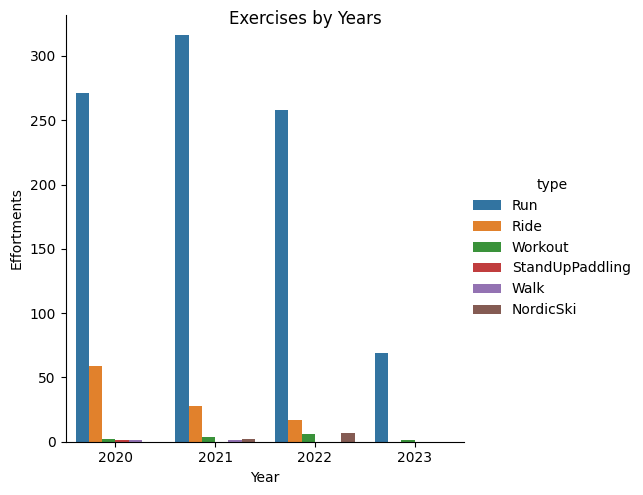

In [21]:
fig = sns.catplot(x='year', hue='type', data=df, kind='count')
fig.fig.suptitle('Exercises by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

Text(0.5, 1.0, 'Exercise Time vs Max Heartrate')

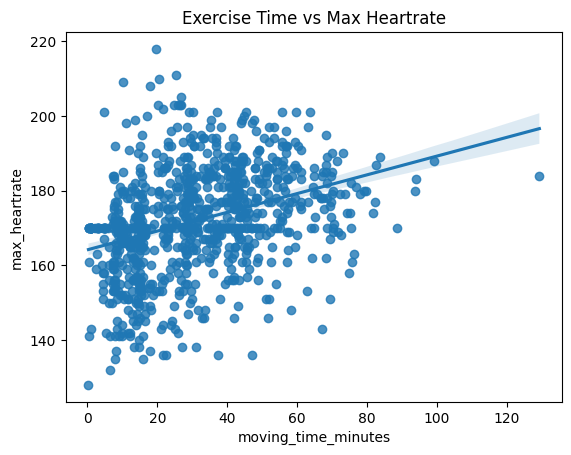

In [22]:
runs = df.loc[df['type'] == 'Run']
sns.regplot(x='moving_time_minutes', y = 'max_heartrate', data=runs).set_title("Exercise Time vs Max Heartrate")

Text(0.5, 1.0, 'Distance vs Max Heartrate')

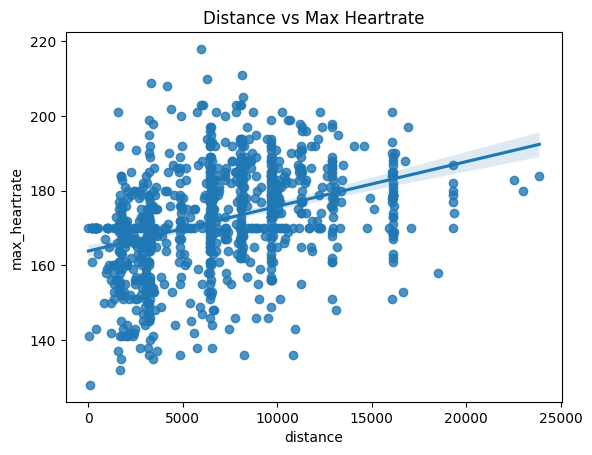

In [23]:
sns.regplot(x='distance', y = 'max_heartrate', data=runs).set_title("Distance vs Max Heartrate")

Text(0.5, 1.0, 'Average Speed vs Max Heartrate')

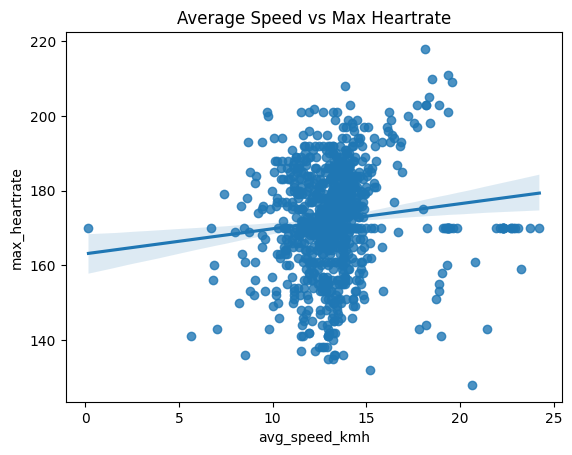

In [37]:
sns.regplot(x='avg_speed_kmh', y = 'max_heartrate', data=runs).set_title("Average Speed vs Max Heartrate")

<AxesSubplot:xlabel='weekday'>

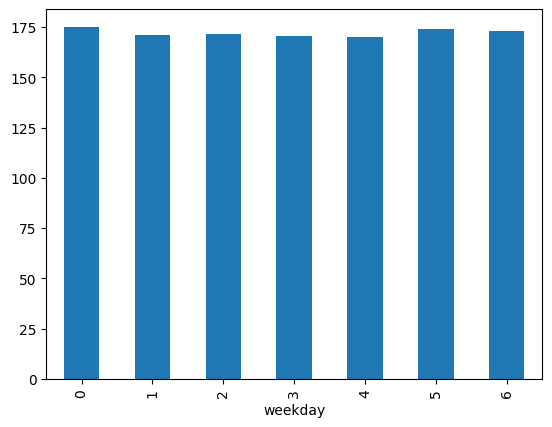

In [24]:
runs.groupby('weekday').mean()['max_heartrate'].plot.bar()

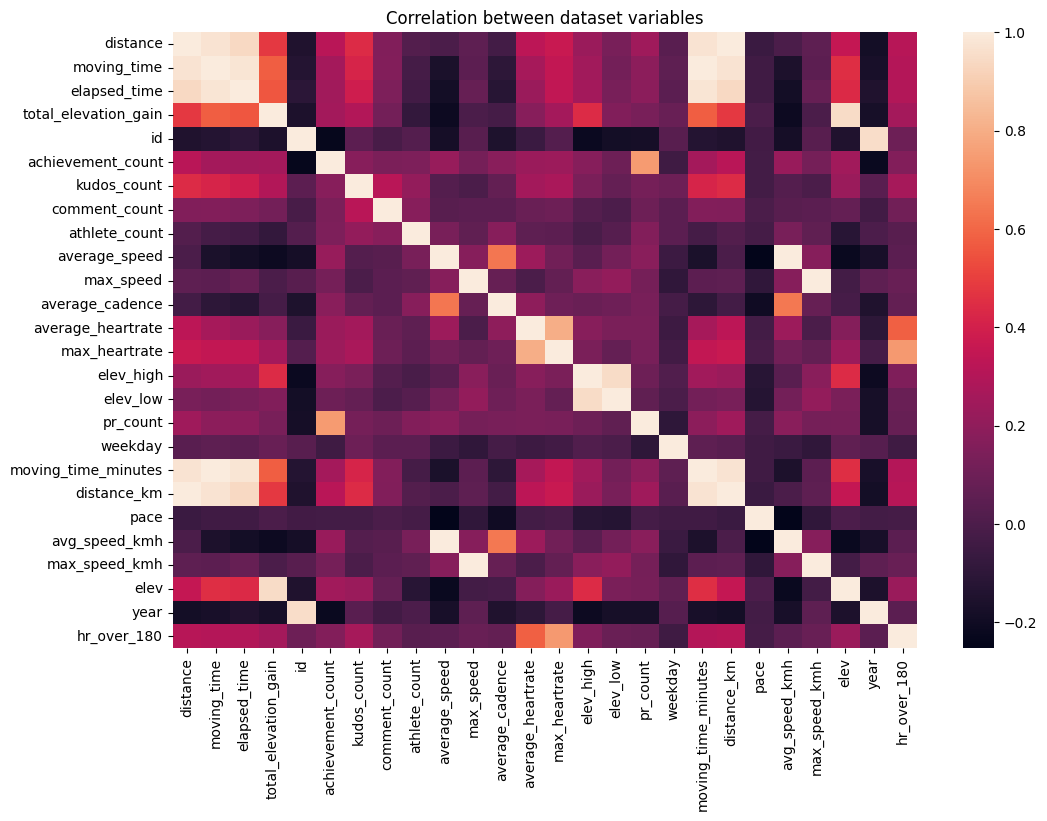

In [25]:
corr = runs.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, fmt=".2f");
plt.title('Correlation between dataset variables')
plt.show()


In [26]:
df.describe()

,distance,moving_time,elapsed_time,total_elevation_gain,id,achievement_count,kudos_count,comment_count,athlete_count,average_speed,...,elev_low,pr_count,weekday,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,year
count,1043.000000,1043.000000,1043.000000,1043.000000,1.043000e+03,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,...,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000
mean,7707.839885,2148.964525,2358.969319,106.287248,5.683803e+09,1.175455,2.956855,0.042186,2.482263,3.669320,...,931.958006,0.388303,2.511026,35.816117,7.707967,8.230056,13.208399,23.387057,85.377085,2021.090125
std,5864.797058,1609.792781,1772.037450,190.558632,1.695330e+09,2.375679,3.389475,0.313092,3.328240,0.779973,...,269.878915,1.115128,1.783542,26.829781,5.864820,54.523022,2.805241,9.959327,154.628622,0.926020
min,9.800000,19.000000,19.000000,0.000000,3.377431e+09,0.000000,0.000000,0.000000,1.000000,0.014000,...,0.000000,0.000000,0.000000,0.320000,0.010000,2.341346,0.050000,0.000000,0.000000,2020.000000
25%,3221.850000,922.000000,967.000000,9.500000,4.072893e+09,0.000000,0.000000,0.000000,1.000000,3.356000,...,972.200000,0.000000,1.000000,15.365000,3.220000,4.263079,12.080000,17.280000,6.400000,2020.000000
50%,6740.400000,1881.000000,2075.000000,28.500000,5.492600e+09,0.000000,2.000000,0.000000,1.000000,3.668000,...,976.600000,0.000000,2.000000,31.350000,6.740000,4.544643,13.200000,20.020000,13.200000,2021.000000
75%,10120.800000,2929.500000,3244.000000,89.950000,7.192521e+09,1.000000,5.000000,0.000000,3.000000,3.910500,...,979.050000,0.000000,4.000000,48.825000,10.120000,4.966147,14.075000,25.920000,67.000000,2022.000000
max,88685.800000,24506.000000,24709.000000,2645.300000,8.760127e+09,16.000000,29.000000,6.000000,68.000000,7.113000,...,1857.000000,12.000000,6.000000,408.430000,88.690000,1184.333333,25.630000,61.920000,800.900000,2023.000000


In [28]:
runs = runs.sample(frac=1).reset_index(drop=True)

categorical_cols = [col for col in runs.columns if runs[col].dtypes == 'O']

useless_vars = ['id', 'achievement_count', 'kudos_count', 'comment_count', 'pr_count','athlete_count','year','weekday']
tweak_runs = runs.drop(categorical_cols+useless_vars, axis=1)
tweak_runs

,distance,moving_time,elapsed_time,total_elevation_gain,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,hr_over_180
0,2084.4,607,607,0.0,3.434,3.910,75.4,150.700000,169.00000,0.0,0.0,10.12,2.08,4.865385,12.33,14.08,0.0,False
1,9029.6,2275,2563,64.3,3.969,6.400,83.0,139.300000,151.00000,979.2,974.5,37.92,9.03,4.199336,14.29,23.04,4.7,False
2,6561.7,1792,1840,26.3,3.662,4.506,78.1,169.200000,180.00000,990.2,977.9,29.87,6.56,4.553354,13.18,16.22,12.3,True
3,6774.4,1733,1733,16.7,3.909,5.310,80.6,158.800000,169.00000,983.9,976.6,28.88,6.77,4.265879,14.07,19.12,7.3,False
4,3215.0,926,932,5.5,3.472,4.400,80.7,139.700000,153.00000,960.9,956.9,15.43,3.22,4.791925,12.52,15.84,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,9648.7,2474,2542,48.5,3.900,5.100,79.8,144.300000,156.00000,998.9,976.7,41.23,9.65,4.272539,14.04,18.36,22.2,False
910,19324.7,4790,4873,154.6,4.034,9.500,80.0,162.100000,180.00000,1256.1,1119.8,79.83,19.32,4.131988,14.52,34.20,136.3,True
911,3426.5,1300,1332,79.0,2.636,5.112,78.0,151.900000,176.00000,835.3,793.6,21.67,3.43,6.317784,9.50,18.40,41.7,False
912,4028.9,1084,1968,134.8,3.717,6.200,79.3,151.332293,169.96986,1199.2,980.4,18.07,4.03,4.483871,13.38,22.32,218.8,False


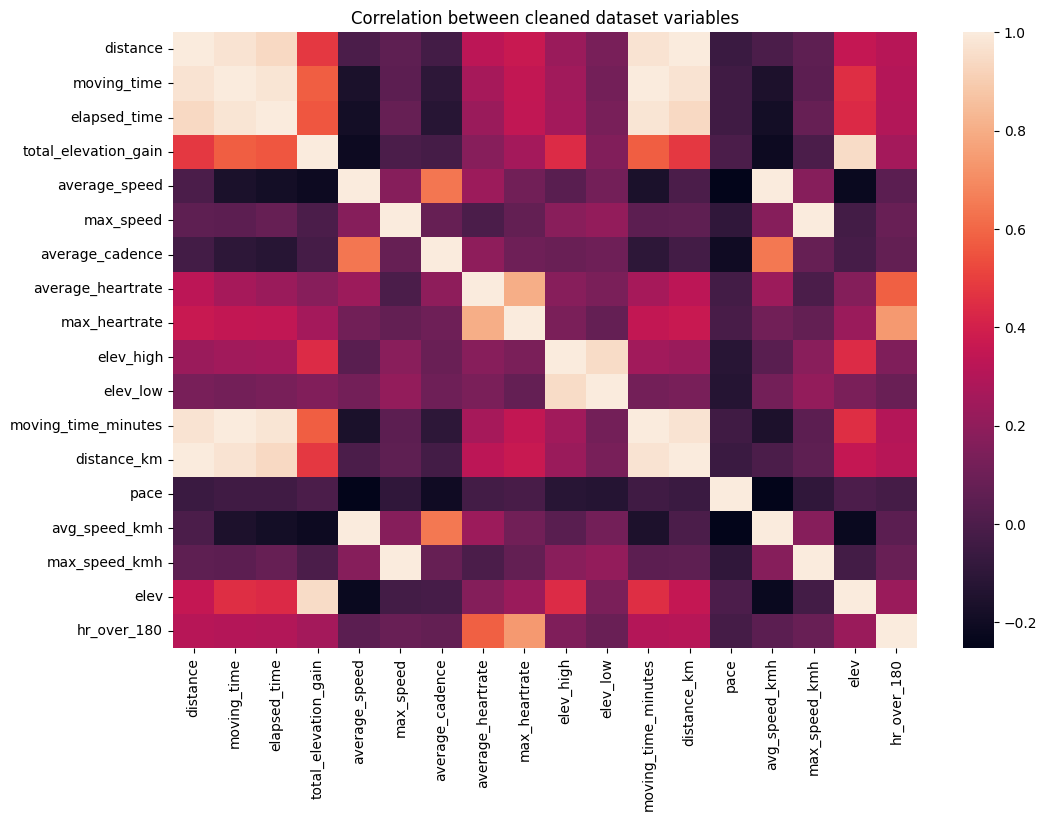

In [33]:
corr = tweak_runs.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, fmt=".2f");
plt.title('Correlation between cleaned dataset variables')
plt.show()

In [30]:
max_hr = df['max_heartrate'].nlargest(10)
print(max_hr)

570    218.0
629    211.0
861    210.0
157    209.0
669    208.0
647    205.0
510    204.0
229    203.0
591    203.0
701    203.0
Name: max_heartrate, dtype: float64


In [48]:
tweak_runs.describe()


,distance,moving_time,elapsed_time,total_elevation_gain,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev
count,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000
mean,6797.030416,1874.416849,2034.979212,61.210832,3.690334,5.855002,79.471001,154.355827,171.994415,978.947374,932.318053,31.240372,6.797144,4.987381,13.283829,21.078074,46.629322
std,4280.375118,1158.596710,1253.955303,98.378908,0.649496,1.769777,3.355225,11.429454,14.043918,284.154124,257.580637,19.310014,4.280419,10.625444,2.334532,6.371177,89.576375
min,9.800000,19.000000,19.000000,0.000000,0.050000,0.000000,53.500000,117.900000,128.000000,0.000000,0.000000,0.320000,0.010000,2.476190,0.180000,0.000000,0.000000
25%,3207.925000,885.250000,922.250000,9.100000,3.373250,4.711500,78.400000,148.525000,165.000000,981.000000,972.200000,14.755000,3.210000,4.296491,12.142500,16.965000,5.400000
50%,6473.700000,1742.500000,1885.500000,25.900000,3.664000,5.400000,79.200000,153.750000,171.000000,989.200000,976.100000,29.040000,6.470000,4.550104,13.185000,19.440000,12.550000
75%,9667.275000,2604.000000,2801.250000,63.875000,3.878250,6.600000,80.100000,161.075000,181.000000,1016.350000,978.500000,43.400000,9.670000,4.940462,13.967500,23.760000,26.375000
max,23872.300000,7756.000000,8027.000000,697.100000,6.887000,15.700000,101.500000,193.600000,218.000000,2126.100000,1845.300000,129.270000,23.870000,325.000000,24.230000,56.520000,618.600000


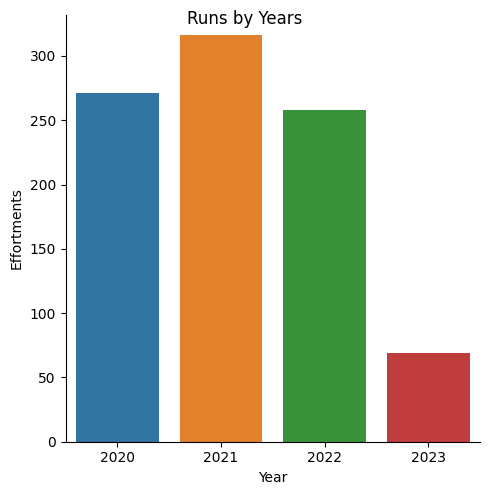

In [32]:
fig = sns.catplot(x='year', data=runs, kind='count')
fig.fig.suptitle('Runs by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

In [38]:
def get_best_rfe_features(X,y, model):
    rfe = RFE(model, step=0.05).fit(X, y)
    selected_features = [i for i, j in zip(X.columns, rfe.support_) if j]
    return selected_features

In [39]:
y = tweak_runs['max_heartrate']
X = tweak_runs.drop('max_heartrate',1)

encoded_y = preprocessing.LabelEncoder().fit_transform(y)
model = LinearRegression()
linear_feats = get_best_rfe_features(X, encoded_y, model)
print(linear_feats)

['average_speed', 'max_speed', 'average_heartrate', 'moving_time_minutes', 'distance_km', 'avg_speed_kmh', 'max_speed_kmh', 'hr_over_180']


/Users/willd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [40]:
y = runs['max_heartrate']
X = runs[linear_feats]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [41]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

MSE: 45.19387221399379


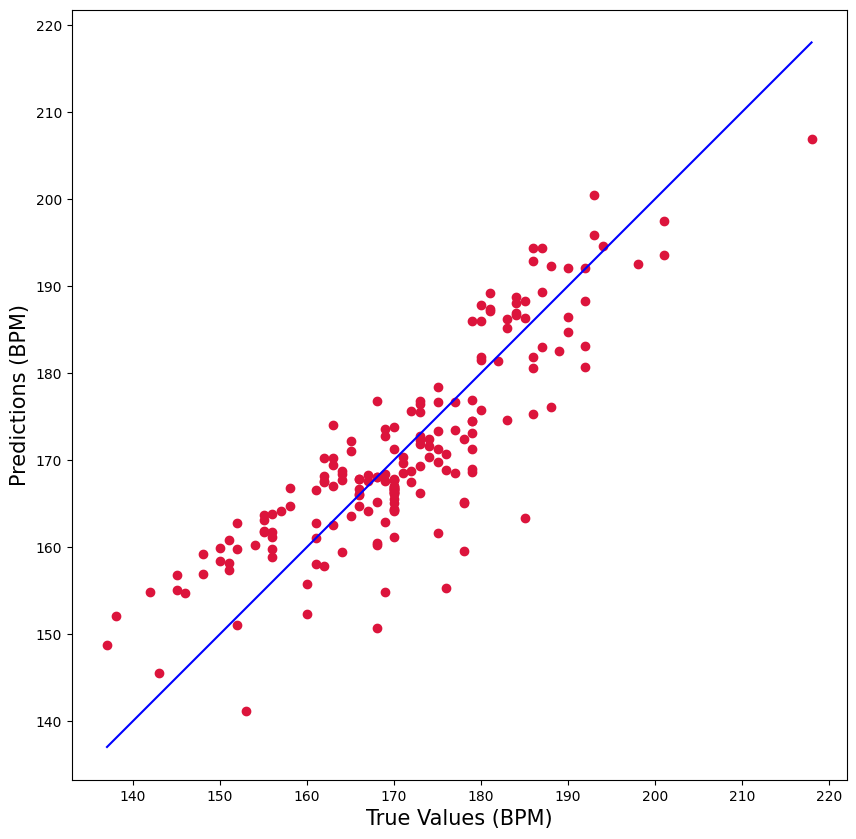

In [42]:
print('MSE:', metrics.mean_squared_error(y_test, y_pred))

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred, c='crimson')


p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values (BPM)', fontsize=15)
plt.ylabel('Predictions (BPM)', fontsize=15)
plt.axis('equal')
plt.show()

In [43]:
model.predict(
    pd.DataFrame(data={ 
        'average_speed': 6.6, 
        'max_speed': 7, 
        'average_heartrate': 160, 
        'moving_time_minutes': 2, 
        'distance_km': .8, 
        'avg_speed_kmh': 23.76, 
        'max_speed_kmh': 25.2, 
        'hr_over_180': True
    },
        index=[0]
    )
)

array([183.45568062])